In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
%store -r X_footsteps_continuous_absolute
%store -r Y_footsteps_continuous_absolute
X_motion = np.concatenate((X_footsteps_accelerations_absolute, X_footsteps_continuous_absolute))
Y_motion = np.concatenate((Y_footsteps_accelerations_absolute, Y_footsteps_continuous_absolute))
print(X_motion.shape)
print(Y_motion.shape)

(1562, 24)
(1562, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where FL/RR are swinging
idxs = np.where(X_motion[:, -2] == 1)[0]
X_motion_RR_swinging = X_motion[idxs]
Y_motion_RR_swinging = Y_motion[idxs]

## Predict RR foot -> x

In [8]:
X_motion_RR_swinging[0, :]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.24316426,  0.12834719, -0.38366681,  0.23878607,
       -0.13193817, -0.36480507, -0.25856626,  0.12253836, -0.36866394,
       -0.25985879, -0.12464122, -0.38309926, -0.00358566, -0.02701497,
       -0.07533848, -0.00298254,  1.        ,  0.        ])

In [9]:
Y_motion_RR_swinging[0, :]

array([-0.00169894, -0.00981897, -0.00087816, -0.01051381])

### Linear Regression

In [10]:
# Input
X = np.hstack((X_motion_RR_swinging[:, :3], # Previous motion command
               X_motion_RR_swinging[:, 3:6], # Current motion command
               X_motion_RR_swinging[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_RR_swinging[:, 6:8], # FL (x,y) position
               X_motion_RR_swinging[:, 9:11], # FR (x,y) position
               X_motion_RR_swinging[:, 12:14], # RL (x,y) position
               X_motion_RR_swinging[:, 15:17])) # RR (x, y) position

# Target
Y = np.array([Y_motion_RR_swinging[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rr_relative_swinging_x = LinearRegression()

# Fit the model
model_rr_relative_swinging_x.fit(X_train, Y_train)

# Predict
predictions = model_rr_relative_swinging_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9878081231959729
RMSE:  0.014784038850248723
The lowest error is:  0.00020547325789332938
The highest error is:  0.07815798047979977
The avg. error is:  0.010585453038359817


In [11]:
model_rr_relative_swinging_x.coef_

array([[ 3.91820029e-02,  5.55111512e-17,  3.46944695e-17,
         1.61264720e-01, -1.94289029e-16,  1.11022302e-16,
         2.52839390e-01,  2.38320301e-01, -1.62148085e-01,
         2.69276285e-02, -7.01669708e-02,  1.28938046e+00,
        -4.79580039e-01, -3.31082856e-01, -1.50437170e+00,
        -8.14391530e-01]])

In [12]:
model_rr_relative_swinging_x.intercept_

array([-0.35375618])

Text(0, 0.5, 'Predictions')

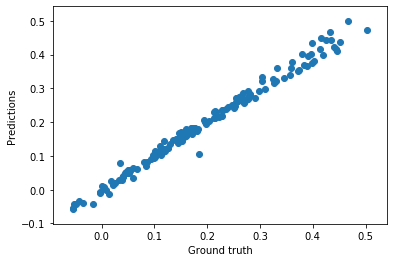

In [13]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [15]:
#%store model_rr_relative_swinging_x

In [16]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [17]:
# Save model
#joblib.dump(model_rr_relative_swinging_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_rr_relative_swinging_x.sav")

### Predict RR foot -> y

In [14]:
# Input
X = np.hstack((X_motion_RR_swinging[:, :3], # Previous motion command
               X_motion_RR_swinging[:, 3:6], # Current motion command
               X_motion_RR_swinging[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_RR_swinging[:, 6:8], # FL (x,y) position
               X_motion_RR_swinging[:, 9:11], # FR (x,y) position
               X_motion_RR_swinging[:, 12:14], # RL (x,y) position
               X_motion_RR_swinging[:, 15:17])) # RR (x, y) position

# Target
Y = np.array([Y_motion_RR_swinging[:, 3]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rr_relative_swinging_y = LinearRegression()

# Fit the model
model_rr_relative_swinging_y.fit(X_train, Y_train)

# Predict
predictions = model_rr_relative_swinging_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.512393365791456
RMSE:  0.006446599654363851
The lowest error is:  1.4729289407738877e-06
The highest error is:  0.017185114370540412
The avg. error is:  0.0048717832691863765


In [15]:
model_rr_relative_swinging_y.coef_

array([[-2.00856830e-02, -6.93889390e-18,  6.67868538e-17,
        -1.11963008e-02,  1.11022302e-16,  1.66533454e-16,
         4.39994481e-02,  6.05916021e-02, -7.42077575e-02,
        -1.04625389e+00, -5.22764336e-02,  4.89383264e-01,
        -5.25300828e-02,  5.22016626e-01,  6.36962525e-02,
        -9.12444679e-01]])

In [16]:
model_rr_relative_swinging_y.intercept_

array([0.05062224])

Text(0, 0.5, 'Predictions')

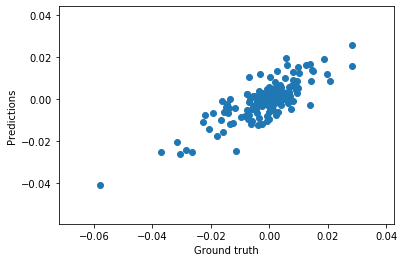

In [17]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [41]:
#for idx, prediction in enumerate(predictions):
#    print(f'Input: {X_test[idx]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')